# Intel Cervical Cancer Screening
### April 21, 2017
## Satchel Grant

### Overview
The goal of this notebook is to classify a woman's cervical type into 1 of 3 classes from medical images. This assists in determination of cancer diagnoses and treatments.

The images are graphic, so I used a different coloring display style when viewing any images.

### Initial Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
import scipy.misc as sci
import time
import random
import scipy.ndimage.interpolation as scizoom

%matplotlib inline

def show(img):
    plt.imshow(img)
    plt.show()

### Reading in the Data
The images are stored as jpg files, stored in folders corresponding to their classification. I read in the image os paths to be converted to images later in batches. I store their classification in a parallel array. 

In [2]:
import os

def read_paths(path, no_labels=False, label_type=None):
    # ** Takes a root path and returns all of the file 
    # paths within the root directory. It uses the 
    # subdirectories to create a corresponding label array **

    # path - the path to the root directory
    # no_labels - optional argument to use file 
    #             names as labels instead of subdirectory
    # label_type - optional argument to set specific label 
    #             type for all files in path
    
    file_paths = []
    labels = []
    labels_to_nums = dict()
    n_labels = None
    for dir_name, subdir_list, file_list in os.walk(path):
        if len(subdir_list) > 0:
            n_labels = len(subdir_list)
            for i,subdir in enumerate(subdir_list):
                labels_to_nums[subdir] = i
        else:
            type_ = dir_name.split('/')[-1]
        for img_file in file_list:
            if '.jpg' in img_file.lower():
                file_paths.append(os.path.join(dir_name,img_file))
                if no_labels: labels.append(img_file)
                elif type(label_type) is int: labels.append(label_type)
                else: labels.append(labels_to_nums[type_])
    if n_labels: return file_paths, labels, n_labels
    return file_paths, labels
    
    


In [3]:
root_path = './train/'
image_paths, labels, n_labels = read_paths(root_path)
image_paths, labels = shuffle(image_paths, labels)

print("Number of data samples: " + str(len(image_paths)))
print("Number of Classes: " + str(n_labels))

Number of data samples: 1481
Number of Classes: 3


### Extra Data
The initial train set is a relatively small number of samples to use for deep learning... Luckily Kaggle provided more samples than just those in the train set. The following cell reads in those files.

In [4]:
paths = ['./Type_1','./Type_2','./Type_3']
for i,path in enumerate(paths):
    new_paths, new_labels = read_paths(path,label_type=i)
    print("Type " + str(i) +": " + str(len(new_paths)))
    image_paths = image_paths + new_paths
    labels = labels + new_labels
print(str(len(image_paths)) + " Total Images")
print(str(len(labels)) + " Total Labels")

Type 0: 2597
Type 1: 3567
Type 2: 3952
11597 Total Images
11597 Total Labels


The following cell displays the distribution of the different cervical types in the dataset.

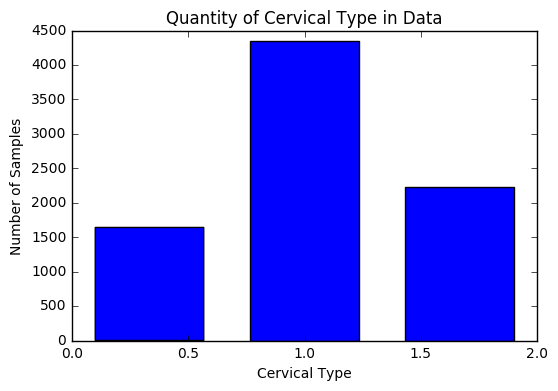

In [7]:
plt.hist(labels,3,rwidth=.7)
plt.title("Quantity of Cervical Type in Data")
plt.xlabel("Cervical Type")
plt.ylabel("Number of Samples")
plt.show()

### Equalize Types
There is an unequal distribution of image data. This can negatively affect the classifier's performance. To make the dataset more equal, this section adds reflections of the underrepresented cervical types to the data.

In [29]:
from PIL import Image

def save(img, path):
    im = Image.fromarray(img)
    im.save(path)
    
def flipped_from_path(path):
    img = mpimg.imread(path)
    return np.fliplr(img)
            
    
def save_flips(path):
    path_additions = []
    label_additions = []
    type_ = int(path[-1])-1
    img_paths, labels = read_paths(path,label_type=type_)
    for p,label in zip(img_paths,labels):
        try:
            flipped_img = flipped_from_path(p)

            split_path = p.split('/')
            split_path[-1] = 'flipped_'+split_path[-1]
            new_path = '/'.join(split_path)
            
            save(flipped_img, new_path)
            
            path_additions.append(new_path)
            label_additions.append(label)
        except OSError:
            print("Error with path: " + p)
    return path_additions, label_additions


In [29]:
paths = ['./Type_1', './Type_3']
for path in paths:
    path_additions, label_additions = save_flips(path)
    image_paths += path_additions
    labels += label_additions
print(str(len(path_additions)) + " additional images")

Error with path: ./Type_1/5893.jpg
Error with path: ./Type_1/3068.jpg
3113 additional images


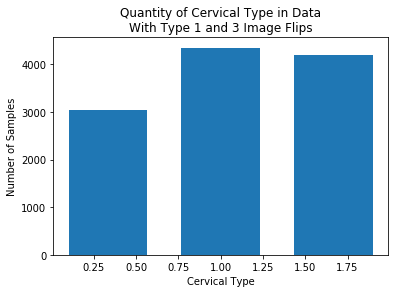

In [6]:
plt.hist(labels,3,rwidth=.7)
plt.title("Quantity of Cervical Type in Data\nWith Type 1 and 3 Image Flips")
plt.xlabel("Cervical Type")
plt.ylabel("Number of Samples")
plt.show()

To boost the type 1 sample count a little more, the next cell flips the images from the original train file.

In [18]:
path = './train/Type_1'
path_additions, label_additions = save_flips(path)
print(str(len(path_additions)) + " additional images")

/home/carnd/anaconda3/envs/obama/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/home/carnd/anaconda3/envs/obama/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/home/carnd/anaconda3/envs/obama/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33554432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/home/carnd/anaconda3/envs/obama/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25165824 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/home/carnd/anaconda3/envs/obama/lib/pyt

Error with path: ./train/Type_1/1339.jpg


/home/carnd/anaconda3/envs/obama/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 548274176 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/home/carnd/anaconda3/envs/obama/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11508. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/home/carnd/anaconda3/envs/obama/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6694150584 bytes but only got 0. Skipping tag 19019
  "Skipping tag %s" % (size, len(data), tag))
/home/carnd/anaconda3/envs/obama/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 687538176 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/home/carnd/anaconda3/e

277 additional images


/home/carnd/anaconda3/envs/obama/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 456589312 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/home/carnd/anaconda3/envs/obama/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206045184 bytes but only got 10111. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


In [21]:
image_paths += path_additions
labels += label_additions

### Split into Training and Validation Sets
It is important to set aside images for validation. This is how you can determine if your model is overfitting or underfitting during training.


In [4]:
training_percentage = .75
total_samples = len(image_paths)
split_index = int(training_percentage*total_samples)

X_train_paths, y_train = image_paths[:split_index], labels[:split_index]
X_valid_paths, y_valid = image_paths[split_index:], labels[split_index:]

NameError: name 'image_paths' is not defined

In [33]:
print("Number of Training Samples: " + str(len(y_train)))
print("Number of Validation Samples: " + str(len(y_valid)))

Number of Training Samples: 8905
Number of Validation Samples: 2969


Since I am completing this notebook over the course of multiple days, I save the training paths and validation paths into seperate csv files along with their classification. This is essentially a checkpoint step so that it is easy to repeatedly save and restore the weights of the model later in the process.

In [34]:
def save_paths(file_name, paths, labels):
    with open(file_name, 'w') as csv_file:
        for path,label in zip(paths,labels):
            csv_file.write(path + ',' + str(label) + '\n')

save_paths('train_set.csv', X_train_paths, y_train)
save_paths('valid_set.csv', X_valid_paths, y_valid)

Now that the paths and labels are saved, we can one_hot encode the labels.

In [6]:
def one_hot_encode(labels, n_classes):
    # ** Takes labels as values and converts them into one_hot labels. 
    # Returns numpy array of one_hot encodings **
    
    # labels - array or numpy array of single valued labels
    # n_classes - number of potential classes in labels
    one_hots = []
    for label in labels:
        one_hot = [0]*n_classes
        if label >= len(one_hot):
            print("Labels out of bounds\nCheck your n_classes parameter")
            return
        one_hot[label] = 1
        one_hots.append(one_hot)
    return np.array(one_hots,dtype=np.float32)


In [35]:
y_train = one_hot_encode(y_train, n_labels)
y_valid = one_hot_encode(y_valid, n_labels)

#### Read In Saved Paths (if restarting notebook session)
Here I read in the training and validation image paths from the csv files. This ensures that the two sets remain seperate throughout the notebook.

In [3]:
def get_split_data(file_name):
    paths = []
    labels = []
    with open(file_name, 'r') as f:
        for line in f:
            split_line = line.strip().split(',')
            paths.append(split_line[0])
            labels.append(int(split_line[1]))
    return paths,labels
            

In [4]:
X_train_paths, y_train = get_split_data('train_set.csv')
X_valid_paths, y_valid = get_split_data('valid_set.csv')
n_labels = max(y_train)+1
print("Number of Training Samples: " + str(len(y_train)))
print("Number of Validation Samples: " + str(len(y_valid)))

Number of Training Samples: 8905
Number of Validation Samples: 2969


In [7]:
y_train = one_hot_encode(y_train, n_labels)
y_valid = one_hot_encode(y_valid, n_labels)

### Data Augmentation
The following cells add rotations and translations to the dataset. This increases the number of samples for training which helps the model generalize better. This prevents overfitting the training set.

In [8]:
def rotate(image, angle, ones=None, random_fill=True, color_range=255):
    # ** Rotates an image by the specified angle amount
    # and fills in resulting space with random values **
    
    # image - the image as numpy array to be rotated
    # angle - the desired amount of rotation in degrees
    # ones - an numpy array of ones like the image with the same rotation
    #        (used for broadcasting random filling into black space from rotation)
    # no_random - optional boolean to remove random filling in black space
    # color_range - the range of color values for the random filling
    
    if not random_fill:
        return sci.imrotate(image, angle).astype(np.float32)
    elif ones == None:
        ones = sci.imrotate(np.ones_like(image),angle)
    rot_image = sci.imrotate(image, angle).astype(np.float32)
    edge_filler = np.random.random(rot_image.shape).astype(np.float32)*color_range
    rot_image[ones[:,:,:]!=1] = edge_filler[ones[:,:,:]!=1]
    return rot_image

def translate(img, row_amt, col_amt, color_range=255):
    # ** Returns a translated copy of an image by the specified row and column amount
    # and fills in the empty space with random values **
    
    # image - the source image as numpy array to be translated
    # row_shift - the maximum vertical translation in both directions in pixels
    # col_shift - the maximum horizontal translation in both directions in pixels
    # color_range - the range of color values for the random filling
    translation = np.random.random(img.shape).astype(img.dtype)*color_range
    if row_amt > 0:
        if col_amt > 0:
            translation[row_amt:,col_amt:] = img[:-row_amt,:-col_amt]
        elif col_amt < 0:
            translation[row_amt:,:col_amt] = img[:-row_amt,-col_amt:]
        else:
            translation[row_amt:,:] = img[:-row_amt,:]
    elif row_amt < 0:
        if col_amt > 0:
            translation[:row_amt,col_amt:] = img[-row_amt:,:-col_amt]
        elif col_amt < 0:
            translation[:row_amt,:col_amt] = img[-row_amt:,-col_amt:]
        else:
            translation[:row_amt,:] = img[-row_amt:,:]
    else:
        if col_amt > 0:
            translation[:,col_amt:] = img[:,:-col_amt]
        elif col_amt < 0:
            translation[:,:col_amt] = img[:,-col_amt:]
        else:
            return img.copy()
    return translation

def random_zoom(image, max_zoom=1/3.):
    # ** Returns a randomly zoomed (scaled) copy of an image within the scaling amount.
    # if the scaling zooms outward, the empty space is filled with random values **
    
    # image - the source image as numpy array to be scaled
    # max_zoom - the maximum scaling amount in either direction
    
    color_range = 255
    zoom_factor = 1 + (random.random()-0.5)*max_zoom
    while zoom_factor == 1:
        zoom_factor = 1 + (random.random()-0.5)*max_zoom
    # scipy's zoom function returns different size array
    # The following code ensures the zoomed image has same pixel size as initial image
    img_height, img_width = image.shape[:2]
    zoomed_h = round(img_height*zoom_factor)
    zoomed_w = round(img_width*zoom_factor)
    diff_h = abs(zoomed_h-img_height)
    diff_w = abs(zoomed_w-img_width)
    start_row = round(diff_h/2)
    start_col = round(diff_w/2)
    
    # Zoom in on image
    if zoom_factor > 1:
        end_row = start_row+img_height
        end_col = start_col+img_width
        zoom_img = scizoom.zoom(image,(zoom_factor,zoom_factor,1),output=np.uint8)[start_row:end_row,
                                                               start_col:end_col]
    # Zoom out on image
    elif zoom_factor < 1:
        temp = scizoom.zoom(image,(zoom_factor,zoom_factor,1),output=np.uint8)
        temp_height, temp_width = temp.shape[:2]
        zoom_img = np.random.random(image.shape)*color_range # Random pixels instead of black space for out zoom
        zoom_img[start_row:start_row+temp_height,
                 start_col:start_col+temp_width] = temp[:,:]
    else:
        return image.copy()
    return zoom_img.astype(np.float32)

def random_augment(image, rotation_limit=180, shift_limit=10, zoom_limit=1/3.):
    # ** Returns a randomly rotated, translated, or scaled copy of an image. **
    
    # image - source image as numpy array to be randomly augmented
    # rotation_limit - maximum rotation degree in either direction
    # shift_limit - maximum translation amount in either direction
    # zoom_limit - maximum scaling amount in either direction
    
    augmentation_type = random.randint(0,2)
    
    # Rotation
    if augmentation_type == 0:
        random_angle = random.randint(-rotation_limit,rotation_limit)
        while random_angle == 0:
            random_angle = random.randint(-rotation_limit,rotation_limit)
        aug_image = rotate(image,random_angle,random_fill=False)
    
    elif augmentation_type == 1:
        # Translation
        row_shift = random.randint(-shift_limit, shift_limit)
        col_shift = random.randint(-shift_limit, shift_limit)
        aug_image = translate(image,row_shift,col_shift)
    
    else:
        # Scale
        aug_image = random_zoom(image,max_zoom=zoom_limit)
    
    return aug_image

### Generator and Image Reader
To maximize memory, the images for both testing and training can be read in in batches. This increases the amount of images that can be trained on in a single epoch which helps the model generalize. In most cases, more training data is better for deep learning. 

In [9]:
def convert_images(paths, labels, resize_dims=(256,256), randomly_augment=False):
    # ** Reads in images from their paths, resizes the images and returns 
    # the images with their corresponding labels. **
    
    # paths - the file paths to the images
    # labels - a numpy array of the corresponding labels to the images
    # resize_dims - the resizing dimensions for the image
    # add_zooms - optional parameter to add randomly scaled copies of the images to the output
    # randomly_augment - optional parameter to add randomly rotated, 
    #                    translated, and scaled images to the output
    
    images = []
    new_labels = []
    for i,path in enumerate(paths):
        label = labels[i]
        try:
            img = mpimg.imread(path)
            resized_img = sci.imresize(img, resize_dims)
        except OSError:
            if i == 0:
                img = mpimg.imread(paths[i+1])
                resized_img = sci.imresize(img, resize_dims)
                resized_img = random_augment(resized_img)
            elif i > 0:
                sub_index = -1
                if randomly_augment:
                    sub_index = -2
                resized_img = random_augment(images[sub_index])
            labels[i] = labels[i-1]
            label = labels[i]
        images.append(resized_img)
        if randomly_augment:
            images.append(random_augment(resized_img))
            new_labels.append(label)
            new_labels.append(label)
    if randomly_augment: 
        return np.array(images,dtype=np.float32), np.array(new_labels,dtype=np.float32)
    return np.array(images,dtype=np.float32), labels



def image_generator(file_paths, labels, batch_size, resize_dims=(256,256), randomly_augment=False):
    # ** Generator function to convert image file paths to images with labels in batches. **
    
    # file_paths - an array of the image file paths as strings
    # labels - a numpy array of labels for the corresponding images
    # batch_size - the desired size of the batch to be returned at each yield
    # resize_dims - the desired x and y dimensions of the images to be read in
    # add_zooms - optional parameter add an additional randomly zoomed image to the batch for each file path
    # randomly_augment - optional parameter add an additional randomly rotated, translated, 
    #         and zoomed image to the batch for each file path
    
    if randomly_augment: 
        batch_size = int(batch_size/2) # the other half of the batch is filled with augmentations
    while 1:
        file_paths,labels = shuffle(file_paths,labels)
        for batch in range(0, len(file_paths), batch_size):
            images, batch_labels = convert_images(file_paths[batch:batch+batch_size], 
                                                  labels[batch:batch+batch_size], 
                                                  resize_dims=resize_dims,
                                                  randomly_augment=randomly_augment)
            yield images, batch_labels



#### Note on Image Generation
The cervical images come in different sizes. Because I may use transfer learning, the images need to be resized anyway.

If the classification results are too poor, I will try resizing without distorting the image. If I am still getting poor results, I will try using RNNs to find the key elements of the picture and crop the image. I may use this last technique regardless of my initial results simply to practice the method. It has proved very successful for other people on other projects in the past.

In [10]:
batch_size = 96
add_random_augmentations = True
resize_dims = (256,256)

n_train_samples = len(X_train_paths)
if add_random_augmentations: 
    n_train_samples = 2*len(X_train_paths)

train_steps_per_epoch = n_train_samples//batch_size + 1
if n_train_samples % batch_size == 0: train_steps_per_epoch = n_train_samples//batch_size

valid_steps_per_epoch = len(X_valid_paths)//batch_size


train_generator = image_generator(X_train_paths, 
                                  y_train, 
                                  batch_size,
                                  resize_dims=resize_dims,
                                  randomly_augment=add_random_augmentations)
valid_generator = image_generator(X_valid_paths, y_valid, 
                                  batch_size, resize_dims=resize_dims)

### Viewing the Images
The following cell shows what some of the images look like. Due to the graphic nature of the images, I left the format in float32 instead of uint8 so that the coloring is less intrusive.

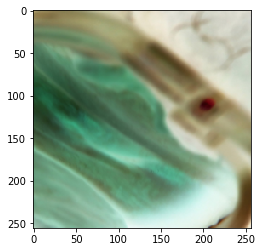

[ 0.  1.  0.]


/home/carnd/anaconda3/envs/obama/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


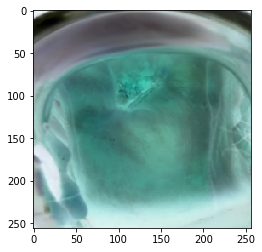

[ 0.  1.  0.]


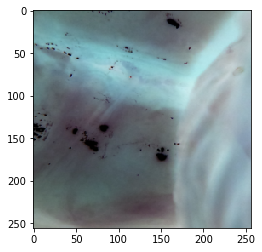

[ 0.  1.  0.]


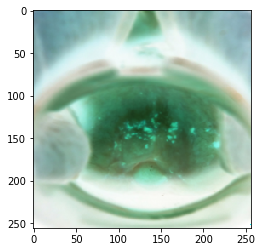

[ 1.  0.  0.]


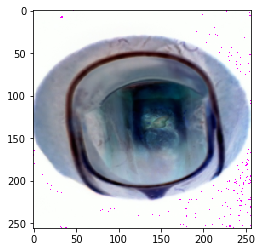

[ 0.  1.  0.]


In [38]:
image_gen = image_generator(X_train_paths[:10], y_train[:10], 2,randomly_augment=True)

for i in range(5):
    imgs, labels = next(image_gen)
    imgs = imgs
    show(imgs[0])
    print(labels[0])

## Keras Section

### Keras Imports


In [11]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Flatten, Dropout, concatenate
from keras.layers.normalization import BatchNormalization
from keras import optimizers


Using TensorFlow backend.


### Keras Model
I'm going to try using a personal model that has given me good success in the past. If it seems to produce bad results, I will likely try to use transfer learning instead and use a model like the Inception net. Cervixes, however, only have so many features that are important to notice. And these features seem more esoteric than the imagenet features that most pretrained models are trained on. My personal model trains quicker and easier than the larger nets and uses newer methods like batchnormalization and parallel convolutions. Thus I'm going to try it first and reevaluate if results are poor.

In [12]:
stacks = []
conv_shapes = [(1,1),(3,3),(5,5)]
conv_depths = [10,10,10,10,10]
pooling_filter = (2,2)
pooling_stride = (2,2)
dense_shapes = [150,64,20,n_labels]

inputs = Input(shape=(resize_dims[0],resize_dims[1],3))
zen_layer = BatchNormalization()(inputs)

for shape in conv_shapes:
    stacks.append(Conv2D(conv_depths[0], shape, padding='same', activation='elu')(inputs))
layer = concatenate(stacks,axis=-1)
layer = BatchNormalization()(layer)
layer = MaxPooling2D(pooling_filter,strides=pooling_stride,padding='same')(layer)
# layer = Dropout(0.05)(layer)

for i in range(1,len(conv_depths)):
    stacks = []
    for shape in conv_shapes:
        stacks.append(Conv2D(conv_depths[i],shape,padding='same',activation='elu')(layer))
    layer = concatenate(stacks,axis=-1)
    layer = BatchNormalization()(layer)
#     layer = Dropout(i*10**-2+.05)(layer)
    layer = MaxPooling2D(pooling_filter,strides=pooling_stride, padding='same')(layer)

layer = Flatten()(layer)
fclayer = Dropout(0.5)(layer)

for i in range(len(dense_shapes)-1):
    fclayer = Dense(dense_shapes[i], activation='elu')(fclayer)
#     if i == 0:
#         fclayer = Dropout(0.5)(fclayer)
    fclayer = BatchNormalization()(fclayer)

outs = Dense(dense_shapes[-1], activation='softmax')(fclayer)



### Keras Training
I read in a pretrained model that was trained on classifying statefarm drivers. Hopefully this will speed up the training process.

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
model = Model(inputs=inputs,outputs=outs)
model.load_weights('model.h5')
learning_rate = 0.001
for i in range(10):
    if i > 5:
        learning_rate = .0001
    adam_opt = optimizers.Adam(lr=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])
    history = model.fit_generator(train_generator, train_steps_per_epoch, epochs=1,
                        validation_data=valid_generator, validation_steps=valid_steps_per_epoch)
    model.save('model.h5')


Epoch 1/1
 13/186 [=>............................] - ETA: 5787s - loss: 1.0978 - acc: 0.4167